In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
freq_test = '2H' # 测试时间周期 '1Min, 5Min, 15Min, 30Min, 1H, 4H, 6H, 8H, 12H, 1D'

## ds.read_bar

**1) path : hdf5文件上级目录**
    
  '.\min_data\VnTrader_1Min_Db' 与 '.\min_data\OANDA_M1'
  
  binance后缀的品种在VnTrader_1Min_Db、oanda后缀的品种在OANDA_M1的位置

**2) props :**

  配置项包括symbol, start_date, end_date , field, freq  
   
  `start_date/end_date` : 20180601000000 (int, 精确到秒，共14位数字)
  
  `symbol` :str/list 
  
  'BTCUSDT:binance,ETHUSDT:binance,EOSUSDT:binance' 与 
   'AUD_USD:oanda,EUR_USD:oanda,GBP_USD:oanda,HK33_HKD:oanda,NAS100_USD:oanda,
   NZD_USD:oanda,USD_CAD:oanda,USD_CHF:oanda,USD_CNH:oanda,USD_JPY:oanda,WTICO_USD:oanda,XAU_USD:oanda'
  
  `freq`  :  str/list
  
  '1Min, 5Min, 15Min, 30Min, 1H, 4H, 6H, 8H, 12H'
  
   配置项均可为空，代表该项读全部

In [3]:
# 1.加载数据
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
import pandas as pd
# 加freq参数

start = time()
path = r'./min_data/OANDA_M1'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'NAS100_USD:oanda', 
         'freq': freq_test,
         'start_date':20180601000000}

# Time_dict = ds.bar_reader(path, props) #读取数据 # props多个时间，Time_dict为字典
Time_df = ds.bar_reader(path, props)
print(time()-start)

2.662368059158325


In [4]:
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv = HFDataView()
dv.create_init_dv(Time_df.dropna(how='all').set_index(["trade_date","symbol"])) # dataview设为双索引
# dv.create_init_dv(Time_dict[freq_test].dropna(how='all').set_index(["trade_date","symbol"])) # dataview设为双索引 # props多个时间，Time_dict为字典

Initialize dataview success.


In [5]:
Open = dv.get_ts("open")
High = dv.get_ts("high")
Low = dv.get_ts("low")
Close = dv.get_ts("close")
Volume = dv.get_ts('volume')

from jaqs_fxdayu.data import signal_function_mod as sfm

# 1.布林带
upperband = sfm.ta(ta_method = 'BBANDS', ta_column=0, timeperiod=20, Open=Open, High=High, Low=Low, Close=Close, Volume=Volume).fillna(method='ffill')
middleband = sfm.ta(ta_method = 'BBANDS', ta_column=1, timeperiod=20, Open=Open, High=High, Low=Low, Close=Close, Volume=Volume).fillna(method='ffill')
lowerband = sfm.ta(ta_method = 'BBANDS', ta_column=2, timeperiod=20, Open=Open, High=High, Low=Low, Close=Close, Volume=Volume).fillna(method='ffill')
dv.append_df(upperband,'upperband')
dv.append_df(middleband,'middleband')
dv.append_df(lowerband,'lowerband')

In [6]:
# 2.RSI相对强弱指标

# 定义指数平均计算函数-传入一个时间为索引,股票为columns的Dataframe,计算其指数平均序列
# SMAtoday=m/n * Pricetoday + ( n-m )/n * SMAyesterday;
def sma(df, n, m):
    a = n / m - 1
    r = df.ewm(com=a, axis=0, adjust=False)
    return r.mean()

dv.add_formula("RSI","(100*SMA(Max((close-Delay(close,1)),0),14,1)/SMA(Abs(close-Delay(close,1)),14,1))",
               add_data=True,
               register_funcs={"SMA":sma}).head()

symbol,NAS100_USD:oanda
trade_date,
20180601000000,NaN
20180601020000,0.000000
20180601040000,3.389831
20180601060000,15.075377
20180601080000,19.158592


In [7]:
# 3.Stoch RSI 随机强弱指标
def STOCHRSI(RSI,T=14,tK=3):
    minRSI = RSI.rolling(window=14).min()
    maxRSI = RSI.rolling(14).max()
    numerator = (RSI - minRSI).rolling(3).mean()
    denominator = (maxRSI - minRSI).rolling(3).mean()
    StochRSI = 100 * numerator/denominator
    return StochRSI
    
StochRSI_K = STOCHRSI(dv.get_ts('RSI').dropna(),T=14,tK=3).dropna() 
dv.append_df(StochRSI_K,'StochRSI_K')
dv.add_formula('StochRSI_D','Ts_Mean(StochRSI_K,3)', add_data=True)

symbol,NAS100_USD:oanda
trade_date,
20180601000000,NaN
20180601020000,NaN
20180601040000,NaN
20180601060000,NaN
20180601080000,NaN
20180601100000,NaN
20180601120000,NaN
20180601140000,NaN
20180601160000,NaN


In [8]:
import numpy as np
# 4.fisher指标
def fisher(high,low, T=9, k=0.5): # k 可为0.33或0.5
    price = (high + low)/2
    delta = price
    fisher = price
    rows = price.shape[0]
    min_T = low.rolling(window=10).min()
    max_T = high.rolling(10).max()
    for i in range(T):
        delta.iloc[i].iloc[0]=0
        fisher.iloc[i].iloc[0]=0
    for i in range(T,rows):
        delta.iloc[i].iloc[0] = k * 2 * ((price.iloc[i].iloc[0]-min_T.iloc[i].iloc[0])/(max_T.iloc[i].iloc[0]-min_T.iloc[i].iloc[0]) - 0.5) + (1-k)*delta.iloc[i-1].iloc[0]
        if (delta.iloc[i].iloc[0]>0.99):
            delta.iloc[i].iloc[0] = 0.999
        elif (delta.iloc[i].iloc[0]<-0.99):
            delta.iloc[i].iloc[0] = -0.999
    for i in range(T+1,rows):
        fisher.iloc[i].iloc[0] = 0.5 * np.log((1+delta.iloc[i].iloc[0])/(1-delta.iloc[i].iloc[0])) + 0.5 * fisher.iloc[i-1].iloc[0]
    return fisher

fisher_df = fisher(dv.get_ts('high').fillna(method='ffill'),dv.get_ts('low').fillna(method='ffill'),9,0.5)
dv.append_df(fisher_df,'fisher')
dv.add_formula('fisher_delay1','Delay(fisher,1)',add_data=True)
dv.get_ts('fisher', date_type='datetime').tail()

symbol,NAS100_USD:oanda
trade_date,
2018-09-21 12:00:00,1.025524
2018-09-21 14:00:00,0.509825
2018-09-21 16:00:00,0.084609
2018-09-21 18:00:00,-0.336277
2018-09-21 20:00:00,-0.854449


In [9]:
# 定义策略
# 进场信号
long = dv.add_formula('long',
                        'If((fisher>Delay(fisher,1))&&(Delay(fisher,1)<Delay(fisher,2))\
                        &&(StochRSI_K>StochRSI_D)\
                        &&(Delay(close>open,1))&&(close>open)\
                        &&(RSI<60)\
                        &&(Max(open,close)<upperband)\
                        ,2,0)',
                        add_data=True)
# (fisher>Delay(fisher,1))&&(Delay(fisher,1)>Delay(fisher,2))&&(Delay(fisher,2)<Delay(fisher,3))\
short = dv.add_formula('short',
                        'If((fisher<Delay(fisher,1))&&(Delay(fisher,1)<Delay(fisher,2))&&(Delay(fisher,2)>Delay(fisher,3))\
                        &&(StochRSI_K<StochRSI_D)\
                        &&(Delay(close,1)<Delay(open,1))&&(close<open)\
                        &&(RSI>40)\
                        &&(Min(open,close)>lowerband)\
                        ,-2,0)',
                        add_data=True)
# (fisher<Delay(fisher,1))&&(Delay(fisher,1)>Delay(fisher,2))\

# 出场信号
close_long = dv.add_formula('closeLong',
                        'If(((fisher<Delay(fisher,1))&&(Delay(fisher,1)>=Delay(fisher,2)))\
                        ||((StochRSI_K<StochRSI_D)&&(Delay(StochRSI_K>=StochRSI_D,1)))\
                        ||(Min(open,close)>upperband)\
                        ||(RSI>70)\
                        ,1,0)',
                        add_data=True)
close_short = dv.add_formula('closeShort',
                        'If(((fisher>Delay(fisher,1))&&(Delay(fisher,1)<=Delay(fisher,2)))\
                        ||((StochRSI_K>StochRSI_D)&&(Delay(StochRSI_K<=StochRSI_D,1)))\
                        ||(Max(open,close)<lowerband)\
                        ||(RSI<30)\
                        ,-1,0)',
                        add_data=True)

In [10]:
#观察出现做多信号的时间点
long_plt = dv.get_ts('long', date_type='datetime')
long_plt[long_plt==2].dropna()
#long_plt[long_plt['NAS100_USD:oanda']==2]

symbol,NAS100_USD:oanda
trade_date,
2018-06-08 12:00:00,2.0
2018-06-11 16:00:00,2.0
2018-06-14 10:00:00,2.0
2018-06-18 14:00:00,2.0
2018-06-25 20:00:00,2.0
2018-07-02 14:00:00,2.0
2018-07-04 08:00:00,2.0
2018-07-05 06:00:00,2.0
2018-07-11 10:00:00,2.0


In [11]:
#观察出现平多仓信号的时间点
closeLong_plt = dv.get_ts('closeLong', date_type='datetime')
closeLong_plt[closeLong_plt==1].dropna()

symbol,NAS100_USD:oanda
trade_date,
2018-06-04 14:00:00,1.0
2018-06-04 16:00:00,1.0
2018-06-04 18:00:00,1.0
2018-06-04 20:00:00,1.0
2018-06-04 22:00:00,1.0
2018-06-05 00:00:00,1.0
2018-06-05 02:00:00,1.0
2018-06-05 04:00:00,1.0
2018-06-05 06:00:00,1.0


In [25]:
# 准备蜡烛图的数据
from matplotlib.pylab import date2num
start = '2018-07-01 22:00:00'# 绘图时间范围
end = '2018-07-07 00:00:00'
data = Time_df.dropna().set_index('datetime').loc[start:end] # dataframe设为datetime单索引 
# data = Time_dict[freq_test].dropna().set_index('datetime').loc[start:end] # dataframe设为datetime单索引 # props多个时间，Time_dict为字典
data['candleTime'] = list(map(date2num, data.index))
candle = data.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

In [27]:
# 准备做多点坐标数据
scatterXL = long_plt[long_plt==2].dropna().index
scatterYL = data.loc[scatterXL].low-15
scatterYL_fisher = dv.get_ts('fisher', date_type='datetime').loc[start:end].loc[scatterXL]-0.5

In [28]:
# 准备平多仓坐标数据
scatterXS= closeLong_plt[closeLong_plt==1].dropna().index
scatterYS = data.loc[scatterXS].high+15
scatterYS_fisher = dv.get_ts('fisher', date_type='datetime').loc[start:end].loc[scatterXS]+0.5

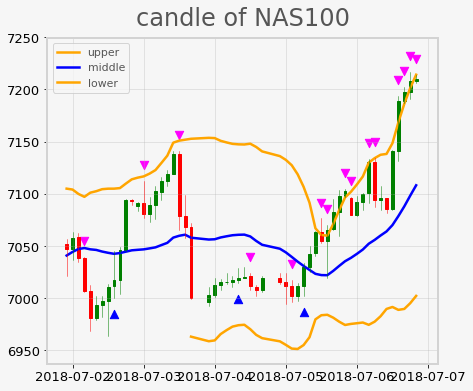

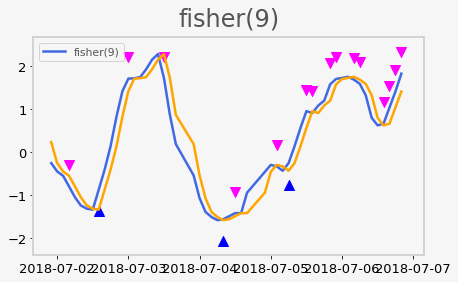

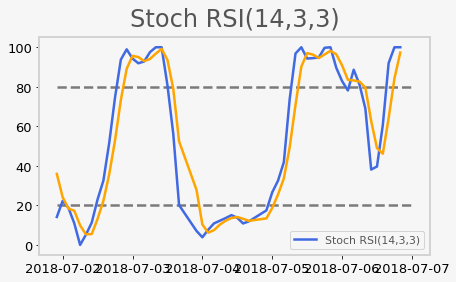

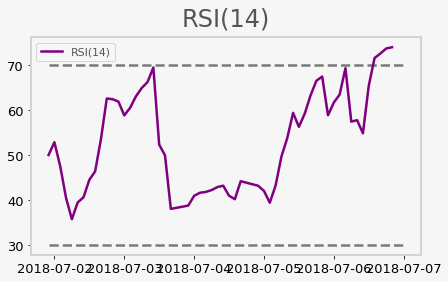

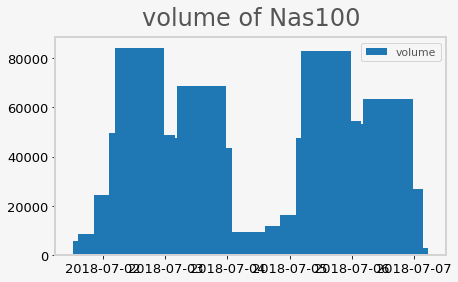

In [29]:
# 绘制蜡烛图和指标曲线

import talib as ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_finance as mpf

fig, (ax) = plt.subplots(1,1,figsize=(7,6))
ax.grid(True)
ax.set_title('candle of NAS100',fontsize=24) 
ax.plot(dv.get_ts('upperband',date_type='datetime').loc[start:end],label = "upper", color='orange',)
ax.plot(dv.get_ts('middleband',date_type='datetime').loc[start:end],label = "middle", color='blue')
ax.plot(dv.get_ts('lowerband',date_type='datetime').loc[start:end].iloc[21:],label = "lower", color='orange')
plt.legend(['upper','middle','lower'])
mpf.candlestick_ohlc(ax, candle, width=0.04, colorup='g', colordown='r',alpha=1.0)
ax.scatter(scatterXL, scatterYL, color='b', s=70, marker='^')
ax.scatter(scatterXS, scatterYS, color='magenta', s=70, marker='v')
ax.xaxis_date()
fig, (ax1) = plt.subplots(1,1,figsize=(7,4))
ax1.set_title('fisher(9)',fontsize=24) 
ax1.plot(dv.get_ts('fisher',date_type='datetime').loc[start:end],label = "fisher", color='royalblue')
plt.legend(['fisher(9)'])
ax1.plot(dv.get_ts('fisher_delay1',date_type='datetime').loc[start:end], color='orange')
ax1.scatter(scatterXL, scatterYL_fisher, color='b', s=100, marker='^')
ax1.scatter(scatterXS, scatterYS_fisher, color='magenta', s=100, marker='v')
ax1.xaxis_date()
fig, (ax2) = plt.subplots(1,1,figsize=(7,4))
ax2.set_title('Stoch RSI(14,3,3)',fontsize=24) 
ax2.plot(dv.get_ts('StochRSI_K',date_type='datetime').loc[start:end],label = "StochRSI_fastk", color='royalblue')
ax2.plot(dv.get_ts('StochRSI_D',date_type='datetime').loc[start:end],label = "StochRSI_fastd", color='orange')
plt.hlines(80, start, end, linestyles='dashed', alpha=0.5)
plt.hlines(20, start, end, linestyles='dashed', alpha=0.5)
plt.legend(['Stoch RSI(14,3,3)'])
ax2.xaxis_date()
fig, (ax3) = plt.subplots(1,1,figsize=(7,4))
ax3.set_title('RSI(14)',fontsize=24) 
ax3.plot(dv.get_ts('RSI',date_type='datetime').loc[start:end],label = "RSI", color='purple')
plt.hlines(70, start, end, linestyles='dashed', alpha=0.5)
plt.hlines(30, start, end, linestyles='dashed', alpha=0.5)
plt.legend(['RSI(14)'])
ax3.xaxis_date()
fig, (ax4) = plt.subplots(1,1,figsize=(7,4))
ax4.set_title('volume of Nas100',fontsize=24) 
ax4.bar(data.index, data.volume)
plt.legend(['volume'])
ax4.xaxis_date()
plt.show()

In [16]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdFisher = TimingDigger(output_folder=".", output_format='pdf',signal_name='Fisher')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

/anaconda3/lib/python3.6/site-packages/jaqs/research/signaldigger/plotting.py:10: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


In [17]:
TimingSignal(tdFisher, dv, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%


In [18]:
tdFisher.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.610  -4.900   0.590
p-value              0.000   0.000   0.560
mean                 0.005  -0.003   0.001
std                  0.003   0.003   0.005
info_ratio           1.619  -1.310   0.113
skewness             1.277  -1.444   0.288
kurtosis             1.780   1.020   0.080
pct5                 0.001  -0.009  -0.008
pct25                0.003  -0.004  -0.003
pct50                0.005  -0.003  -0.001
pct75                0.006  -0.001   0.004
pct95                0.010  -0.001   0.007
occurance           13.000  15.000  28.000
win_ratio              NaN     NaN   0.464
win_mean/loss_mean     NaN     NaN   1.525


In [19]:
tdFisher.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              4.385 -5.321   0.487
p-value             0.002  0.001   0.633
mean                0.004 -0.003   0.001
std                 0.003  0.002   0.004
info_ratio          1.550 -1.881   0.118
skewness           -0.010 -0.403   0.293
kurtosis           -1.316 -0.433  -1.085
pct5                0.000 -0.006  -0.006
pct25               0.003 -0.003  -0.003
pct50               0.004 -0.003  -0.000
pct75               0.007 -0.002   0.004
pct95               0.008 -0.001   0.007
occurance           9.000  9.000  18.000
win_ratio             NaN    NaN   0.500
win_mean/loss_mean    NaN    NaN   1.321


In [20]:
tdFisher.create_event_report(sig_type="long_short") #同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.191  -6.918   0.769
p-value              0.000   0.000   0.446
mean                 0.005  -0.003   0.001
std                  0.003   0.002   0.005
info_ratio           1.569  -1.442   0.115
skewness             0.939  -1.401   0.296
kurtosis             1.454   1.519  -0.126
pct5                 0.001  -0.009  -0.006
pct25                0.003  -0.004  -0.003
pct50                0.004  -0.003  -0.001
pct75                0.007  -0.002   0.004
pct95                0.008  -0.001   0.007
occurance           22.000  24.000  46.000
win_ratio              NaN     NaN   0.478
win_mean/loss_mean     NaN     NaN   1.442
